In [64]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [65]:
import sqlalchemy
from sqlalchemy import create_engine, MetaData
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine, inspect, func

In [66]:
import numpy as np
import pandas as pd

In [67]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [68]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [69]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [70]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [71]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [72]:
# Get a list of column names and types
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [73]:
# Get a list of column names and types
inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [74]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [75]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
last_year_precip = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
#last_year_precip
# Perform a query to retrieve the data and precipitation scores
precip_score = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= last_year_precip).\
                    group_by(Measurement.date).all()
#precip_score
# Save the query results as a Pandas DataFrame and set the index to the date column
score_df= pd.DataFrame(precip_score, columns=['Date', 'Precipitation Score'])
score_df.set_index('Date', inplace=True)

# Sort the dataframe by date
score_df.sort_values("Date", inplace=True)
score_df.head()


,Precipitation Score
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


<function matplotlib.pyplot.show(*args, **kw)>

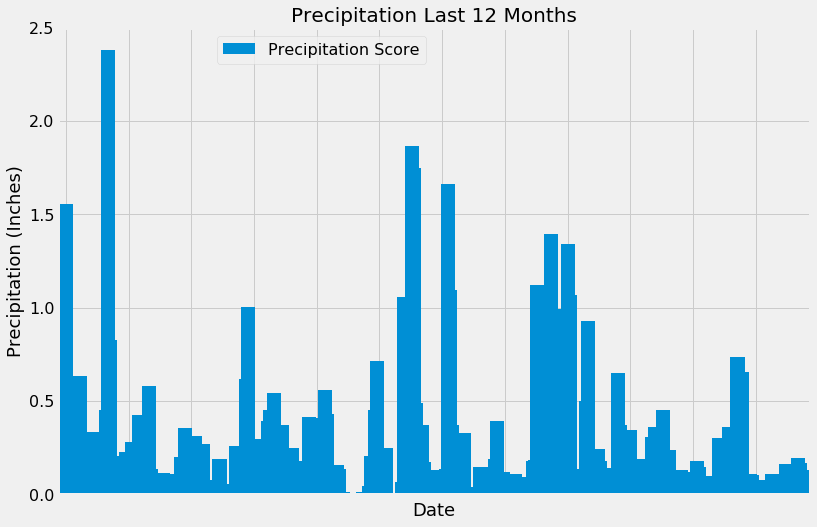

In [77]:

# Use Pandas Plotting with Matplotlib to plot the data
ax = score_df.plot(kind='bar', width=7, figsize=(12,8))
plt.locator_params(axis='x', nbins=12)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(.5,1), fontsize="16")
plt.title("Precipitation Last 12 Months", size=20)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
#plt.savefig("Output/Precipitation.png")
plt.show

![precipitation](Images/precipitation.png)

In [78]:
# Use Pandas to calcualte the summary statistics for the precipitation data
score_df.describe()

,Precipitation Score
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


![describe](Images/describe.png)

In [79]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(func.count(Station.station)).first()
number_of_stations

(9)

In [80]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [81]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_stats = active_stations[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == active_stats).all() 

[(54.0, 71.66378066378067, 85.0)]

In [82]:
# Choose the station with the highest number of temperature observations.
top_temp_station= session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_temp_year = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == active_stats).\
                filter(Measurement.date >= last_year_precip).all()
top_temp_year_df = pd.DataFrame(top_temp_year, columns=['Station', 'Observable Temperature'])
top_temp_year_df.set_index('Station', inplace=True)
top_temp_year_df.head()

,Observable Temperature
Station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


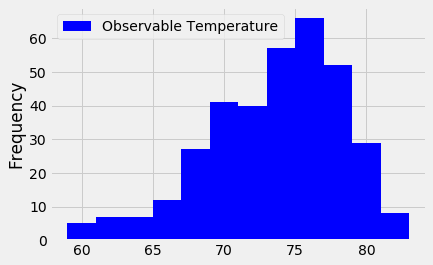

In [85]:
top_temp_year_df.plot(kind='hist', y='Observable Temperature', bins=12, color='blue')
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


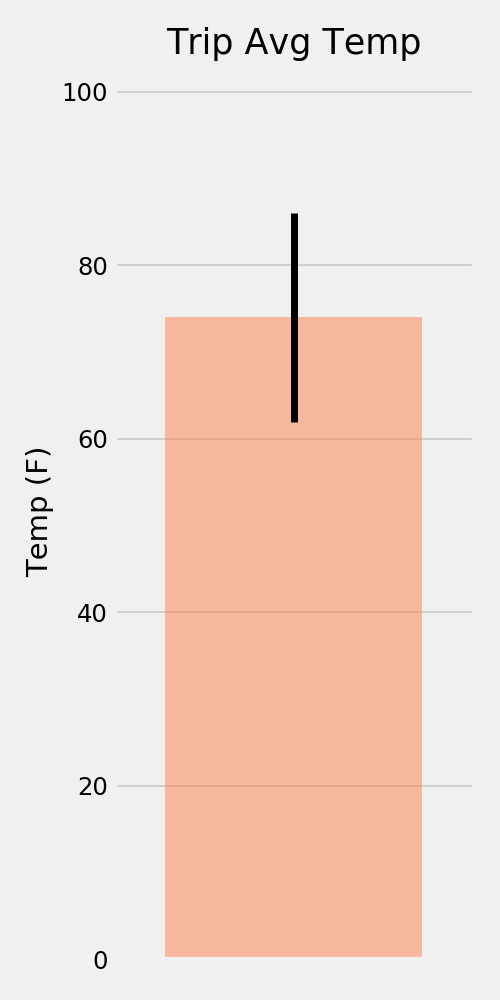

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


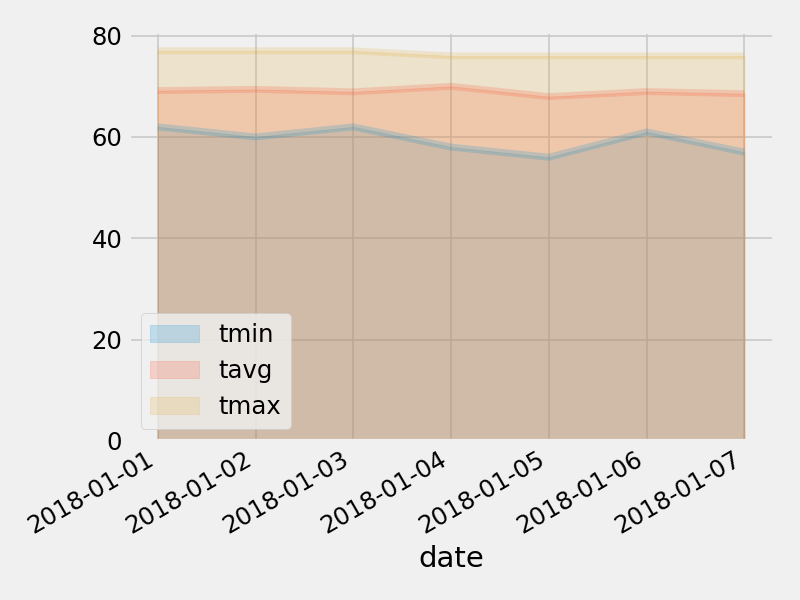

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
